In [13]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
# deletion of files 
import os
import shutil
directory_to_empty = '/kaggle/working/'

for file in os.listdir(directory_to_empty):
    file_path = os.path.join(directory_to_empty, file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
       `     print(f"{file_path} has been deleted.")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"{file_path} has been deleted.")
    except Exception as e:
        print(f"Error: {e}")


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the paths to your original folders and the new destination folders
original_real_folder = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real/'
original_fake_folder = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/'
destination_train_folder = '/kaggle/working/train/'
destination_test_folder = '/kaggle/working/test/'

# Create training and test directories if they don't exist
os.makedirs(destination_train_folder, exist_ok=True)
os.makedirs(destination_test_folder, exist_ok=True)

# Function to copy files to the destination folder
def copy_files(file_list, source_folder, destination_folder):
    for file in file_list:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(destination_folder, file)
        shutil.copy(source_path, destination_path)

# Get the list of files in each original folder
real_files = os.listdir(original_real_folder)
fake_files = os.listdir(original_fake_folder)

# Split the data into training and test sets for real images
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)

# Create subdirectories for real images within train and test folders
destination_train_real_folder = os.path.join(destination_train_folder, 'real')
destination_test_real_folder = os.path.join(destination_test_folder, 'real')
os.makedirs(destination_train_real_folder, exist_ok=True)
os.makedirs(destination_test_real_folder, exist_ok=True)

# Copy real images to the corresponding subdirectories
copy_files(real_train, original_real_folder, destination_train_real_folder)
copy_files(real_test, original_real_folder, destination_test_real_folder)

# Split the data into training and test sets for fake images
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)

# Create subdirectories for fake images within train and test folders
destination_train_fake_folder = os.path.join(destination_train_folder, 'fake')
destination_test_fake_folder = os.path.join(destination_test_folder, 'fake')
os.makedirs(destination_train_fake_folder, exist_ok=True)
os.makedirs(destination_test_fake_folder, exist_ok=True)

# Copy fake images to the corresponding subdirectories
copy_files(fake_train, original_fake_folder, destination_train_fake_folder)
copy_files(fake_test, original_fake_folder, destination_test_fake_folder)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

batch_size = 64

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)

# Normalization for testing (no data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for the training and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)


Found 1632 images belonging to 2 classes.
Found 409 images belonging to 2 classes.


In [3]:
# Check the shape of the first batch from the training generator
images, labels = train_generator.next()
print("Shape of the training batch images:", images.shape)
print("Shape of the training batch labels:", labels.shape)

# Check the shape of the first batch from the testing generator
images, labels = test_generator.next()
print("Shape of the testing batch images:", images.shape)
print("Shape of the testing batch labels:", labels.shape)


Shape of the training batch images: (32, 224, 224, 3)
Shape of the training batch labels: (32,)
Shape of the testing batch images: (32, 224, 224, 3)
Shape of the testing batch labels: (32,)


### VGG-16 (pretrained)

In [8]:
from keras.applications import VGG16
from keras import layers, models, optimizers




# Load pre-trained VGG16 model without the top (fully connected) layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of the pre-trained VGG16
model_vgg16 = models.Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(layers.GlobalAveragePooling2D())
model_vgg16.add(layers.Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification


# Freeze the convolutional base
base_model_vgg16.trainable = False

# Compile the model with a lower learning rate
model_vgg16.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the model with frozen convolutional base
history_vgg16_frozen = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Unfreeze the convolutional base
base_model_vgg16.trainable = True

# Recompile the model with a smaller learning rate
model_vgg16.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Continue training the model with unfrozen convolutional base
history_vgg16_unfrozen = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # You can adjust the number of epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
51/51 [==============================] - 39s 629ms/step - loss: 0.6963 - accuracy: 0.5178 - val_loss: 0.6876 - val_accuracy: 0.5729
Epoch 2/5
51/51 [==============================] - 33s 643ms/step - loss: 0.6880 - accuracy: 0.5343 - val_loss: 0.6860 - val_accuracy: 0.5260
Epoch 3/5
51/51 [==============================] - 33s 641ms/step - loss: 0.6874 - accuracy: 0.5386 - val_loss: 0.6793 - val_accuracy: 0.5990
Epoch 4/5
51/51 [==============================] - 33s 637ms/step - loss: 0.6803 - accuracy: 0.5852 - val_loss: 0.6740 - val_accuracy: 0.5833
Epoch 5/5
51/51 [==============================] - 33s 648ms/step - loss: 0.6794 - accuracy: 0.5650 - val_loss: 0.6815 - val_accuracy: 0.5469
Epoch 1/10
51/51 [==============================] - 45s 658ms/step - loss: 15.5881 - accuracy: 0.5294 - val_loss: 0.6919 - val_accuracy: 0.5365
Epoch 2/10
51/51 [==============================] - 34s 658ms/step - loss: 0.7050

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_vgg16.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 3s 275ms/step - loss: 0.6638 - accuracy: 0.5990
Test Accuracy: 0.5989583134651184


### VGG-19

In [8]:
from keras.applications import VGG19

# Load pre-trained VGG19 model without the top (fully connected) layers
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of the pre-trained VGG19
model_vgg19 = models.Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(layers.GlobalAveragePooling2D())
model_vgg19.add(layers.Dense(1, activation='sigmoid'))

# Freeze the convolutional base
base_model_vgg19.trainable = False

# Compile the model with a lower learning rate
model_vgg19.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the model with frozen convolutional base
history_vgg19_frozen = model_vgg19.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Unfreeze the convolutional base
base_model_vgg19.trainable = True

# Recompile the model with a smaller learning rate
model_vgg19.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Continue training the model with unfrozen convolutional base
history_vgg19_unfrozen = model_vgg19.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/5
51/51 [==============================] - 34s 644ms/step - loss: 0.6990 - accuracy: 0.4951 - val_loss: 0.6877 - val_accuracy: 0.5182
Epoch 2/5
51/51 [==============================] - 32s 634ms/step - loss: 0.6917 - accuracy: 0.5214 - val_loss: 0.6812 - val_accuracy: 0.5469
Epoch 3/5
51/51 [==============================] - 34s 671ms/step - loss: 0.6862 - accuracy: 0.5312 - val_loss: 0.6786 - val_accuracy: 0.5365
Epoch 4/5
51/51 [==============================] - 32s 633ms/step - loss: 0.6824 - accuracy: 0.5558 - val_loss: 0.6810 - val_accuracy: 0.5911
Epoch 5/5
51/51 [==============================] - 32s 630ms/step - loss: 0.6791 - accuracy: 0.5613 - val_loss: 0.6738 - val_accuracy: 0.5755
Epoch 1/10
51/51 [==============================] - 45s 643ms/step - loss: 280.7368 - accuracy: 0.5067 - val_loss: 0.6930 - val_accuracy: 0.5234
Epoch 2/10
51/51 [==============================] - 33s 647ms/step - loss: 0.692

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_vgg19.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 3s 264ms/step - loss: 0.6911 - accuracy: 0.5339
Test Accuracy: 0.5338541865348816


### InceptionV3

In [11]:
from keras.applications import InceptionV3

# Load pre-trained InceptionV3 model without the top (fully connected) layers
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of the pre-trained InceptionV3
model_inception = models.Sequential()
model_inception.add(base_model_inception)
model_inception.add(layers.GlobalAveragePooling2D())
model_inception.add(layers.Dense(1, activation='sigmoid'))

# Freeze the convolutional base
base_model_inception.trainable = False

# Compile the model with a lower learning rate
model_inception.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train the model with frozen convolutional base
history_inception_frozen = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Unfreeze the convolutional base
base_model_inception.trainable = True

# Recompile the model with a smaller learning rate
model_inception.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Continue training the model with unfrozen convolutional base
history_inception_unfrozen = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/5
51/51 [==============================] - 39s 648ms/step - loss: 0.7582 - accuracy: 0.4926 - val_loss: 0.7071 - val_accuracy: 0.5130
Epoch 2/5
51/51 [==============================] - 32s 635ms/step - loss: 0.7110 - accuracy: 0.5447 - val_loss: 0.7573 - val_accuracy: 0.5365
Epoch 3/5
51/51 [==============================] - 32s 637ms/step - loss: 0.6955 - accuracy: 0.5594 - val_loss: 0.7235 - val_accuracy: 0.5495
Epoch 4/5
51/51 [==============================] - 32s 633ms/step - loss: 0.6864 - accuracy: 0.5870 - val_loss: 0.6859 - val_accuracy: 0.5807
Epoch 5/5
51/51 [==============================] - 32s 629ms/step - loss: 0.6735 - accuracy: 0.5968 - val_loss: 0.7624 - val_accuracy: 0.5052
Epoch 1/10
51/51 [==============================] - 65s 700ms/step - loss: 0.7330 - accuracy: 0.5055 - val_loss: 0.7240 - val_accuracy: 0.4792
Epoch 2/10
51/51 [==============================] - 33s 642ms/step - loss: 0.7058 

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_inception.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 3s 260ms/step - loss: 5.0281 - accuracy: 0.5443
Test Accuracy: 0.5442708134651184


### MobileNetV2

In [6]:
from keras.applications import MobileNetV2
from keras import layers, models, optimizers

# Load pre-trained MobileNetV2 model without the top (fully connected) layers
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of the pre-trained MobileNetV2
model_mobilenet = models.Sequential()
model_mobilenet.add(base_model_mobilenet)
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(1, activation='sigmoid'))

# Freeze the convolutional base
base_model_mobilenet.trainable = False

# Compile the model with a lower learning rate
model_mobilenet.compile(optimizer=optimizers.RMSprop(lr=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train the model with frozen convolutional base
history_mobilenet_frozen = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Unfreeze the convolutional base
base_model_mobilenet.trainable = True

# Recompile the model with a smaller learning rate
model_mobilenet.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Continue training the model with unfrozen convolutional base
history_mobilenet_unfrozen = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
25/25 [==============================] - 38s 1s/step - loss: 0.7348 - accuracy: 0.5166 - val_loss: 0.6911 - val_accuracy: 0.5651
Epoch 2/10
25/25 [==============================] - 34s 1s/step - loss: 0.6978 - accuracy: 0.5517 - val_loss: 0.6969 - val_accuracy: 0.5964
Epoch 3/10
25/25 [==============================] - 34s 1s/step - loss: 0.6795 - accuracy: 0.5733 - val_loss: 0.6806 - val_accuracy: 0.5729
Epoch 4/10
25/25 [==============================] - 34s 1s/step - loss: 0.6745 - accuracy: 0.5944 - val_loss: 0.6737 - val_accuracy: 0.5729
Epoch 5/10
25/25 [==============================] - 34s 1s/step - loss: 0.6577 - accuracy: 0.6250 - val_loss: 0.6684 - val_accuracy: 0.5833
Epoch 6/10
25/25 [==============================] - 34s 1s/step - loss: 0.6586 - accuracy: 0.6116 - val_loss: 0.7087 - val_accuracy: 0.5260
Epoch 7/10
25/25 [==============================] - 34s 1s/step - loss: 0.6509 - accuracy: 0.6154

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


In [ ]:
# Continue training the model with unfrozen convolutional base
history_mobilenet_unfrozen = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/10
25/25 [==============================] - 34s 1s/step - loss: 0.2454 - accuracy: 0.8986 - val_loss: 1.9087 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 34s 1s/step - loss: 0.2378 - accuracy: 0.9024 - val_loss: 1.7267 - val_accuracy: 0.5339
Epoch 3/10
25/25 [==============================] - 34s 1s/step - loss: 0.2449 - accuracy: 0.9018 - val_loss: 2.0753 - val_accuracy: 0.5260
Epoch 4/10
25/25 [==============================] - 34s 1s/step - loss: 0.1915 - accuracy: 0.9235 - val_loss: 2.3874 - val_accuracy: 0.4818
Epoch 5/10
25/25 [==============================] - 34s 1s/step - loss: 0.2187 - accuracy: 0.9203 - val_loss: 2.8001 - val_accuracy: 0.5339
Epoch 6/10
25/25 [==============================] - 34s 1s/step - loss: 0.2212 - accuracy: 0.9094 - val_loss: 1.7877 - val_accuracy: 0.5755
Epoch 7/10
 6/25 [======>.......................] - ETA: 22s - loss: 0.1428 - accuracy: 0.9557

In [19]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_inception.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 4s 282ms/step - loss: 4.6308 - accuracy: 0.5443
Test Accuracy: 0.5442708134651184


### Resnet50

In [20]:
from keras.applications import ResNet50

# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of the pre-trained ResNet50
model_resnet = models.Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(layers.GlobalAveragePooling2D())
model_resnet.add(layers.Dense(1, activation='sigmoid'))

# Freeze the convolutional base
base_model_resnet.trainable = False

# Compile the model with a lower learning rate
model_resnet.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model with frozen convolutional base
history_resnet_frozen = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Unfreeze the convolutional base
base_model_resnet.trainable = True

# Recompile the model with a smaller learning rate
model_resnet.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Continue training the model with unfrozen convolutional base
history_resnet_unfrozen = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/5
51/51 [==============================] - 40s 700ms/step - loss: 0.6966 - accuracy: 0.5325 - val_loss: 0.6917 - val_accuracy: 0.5208
Epoch 2/5
51/51 [==============================] - 34s 657ms/step - loss: 0.6961 - accuracy: 0.5086 - val_loss: 0.6906 - val_accuracy: 0.5260
Epoch 3/5
51/51 [==============================] - 33s 646ms/step - loss: 0.6992 - accuracy: 0.4890 - val_loss: 0.6951 - val_accuracy: 0.5234
Epoch 4/5
51/51 [==============================] - 34s 657ms/step - loss: 0.6956 - accuracy: 0.5196 - val_loss: 0.6901 - val_accuracy: 0.5260
Epoch 5/5
51/51 [==============================] - 33s 653ms/step - loss: 0.6966 - accuracy: 0.5135 - val_loss: 0.6914 - val_accuracy: 0.5417
Epoch 1/10
51/51 [==============================] - 61s 667ms/step - loss: 1.0671 - accuracy: 0.5374 - val_loss: 1.4075 - val_accuracy: 0.4661
Epoch 2/10
51/51 [==============================] - 36s 697ms/step - loss: 0.7467 

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 3s 273ms/step - loss: 0.6915 - accuracy: 0.5312
Test Accuracy: 0.53125


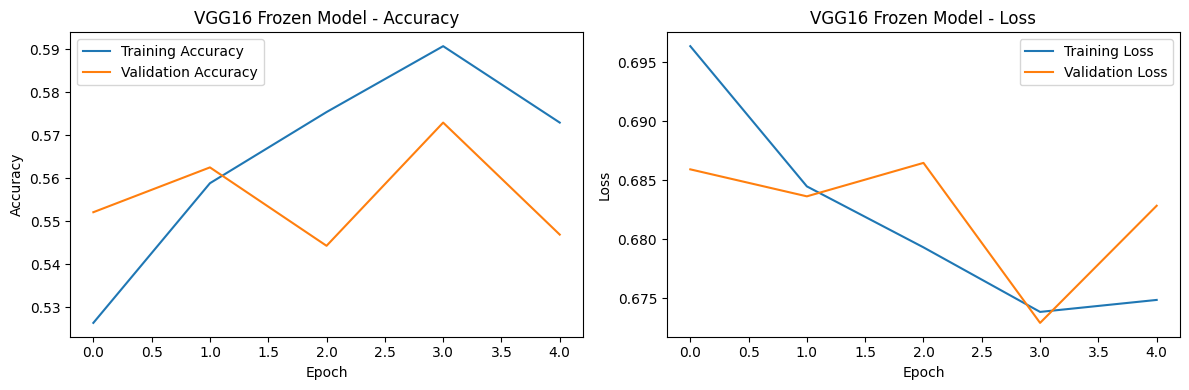

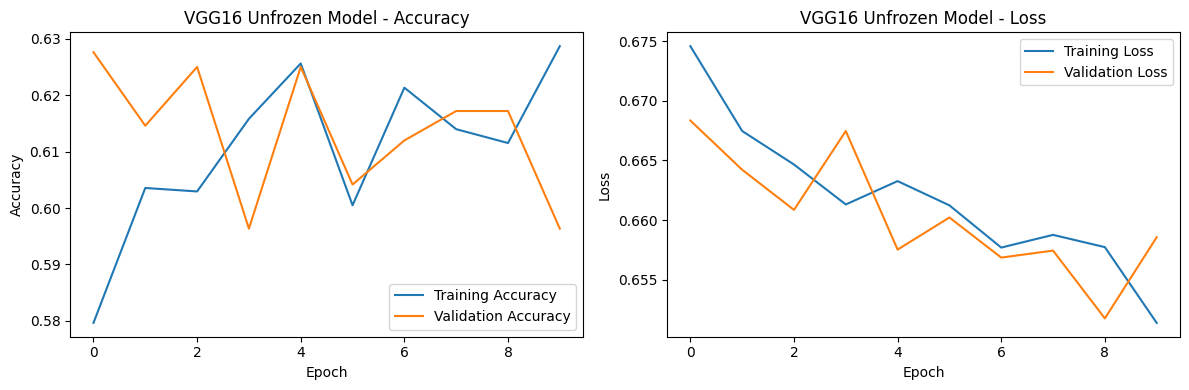

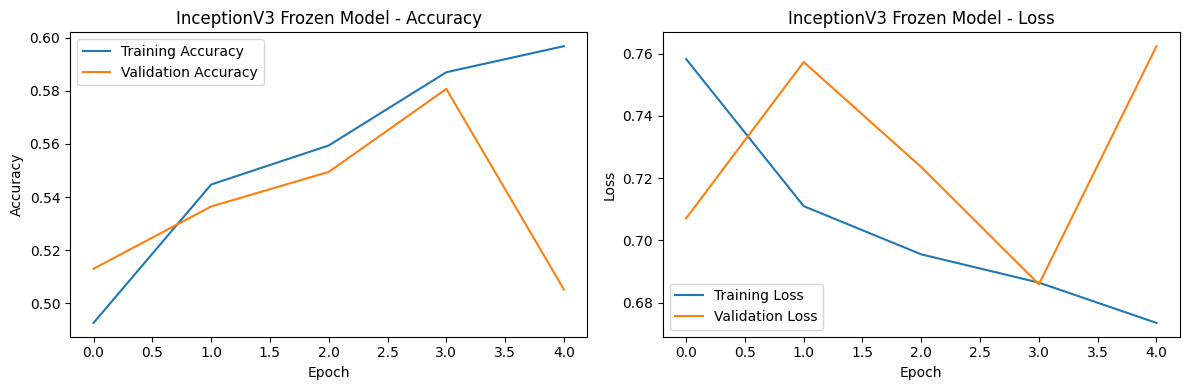

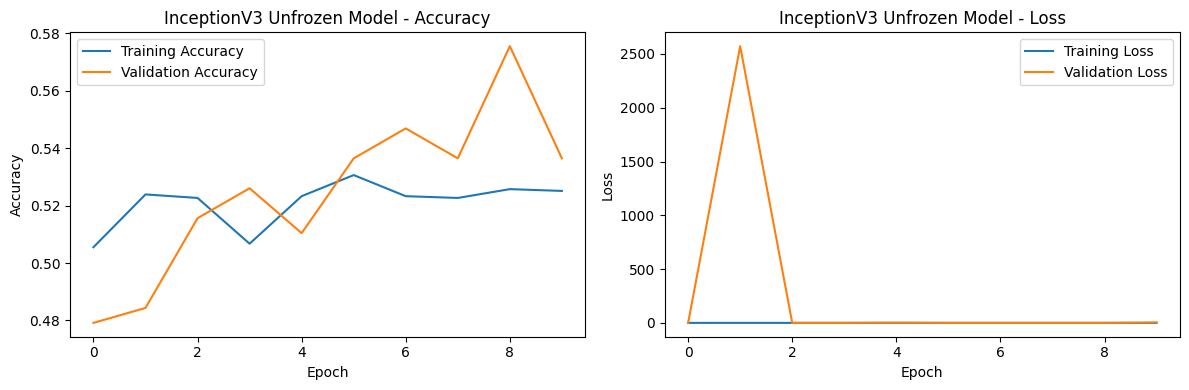

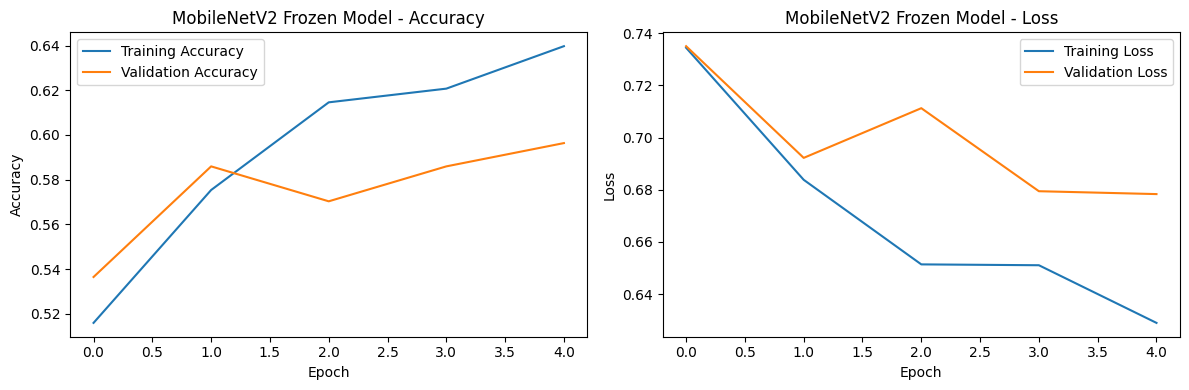

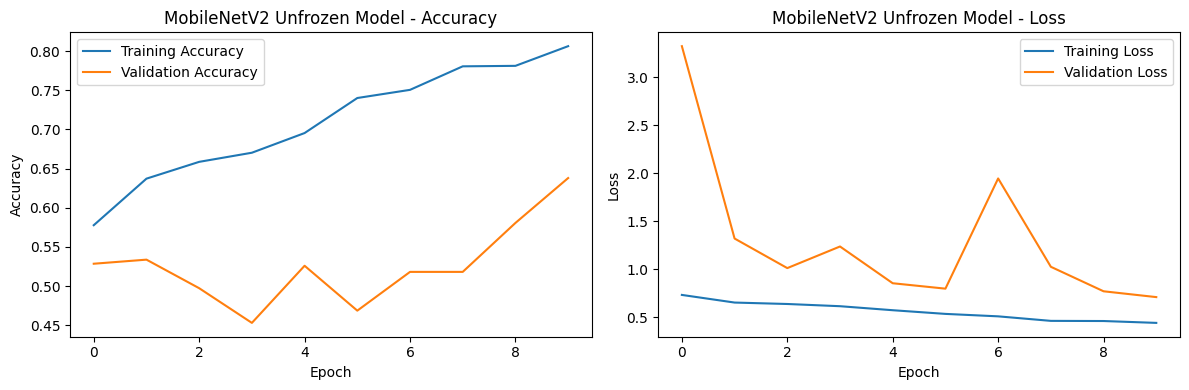

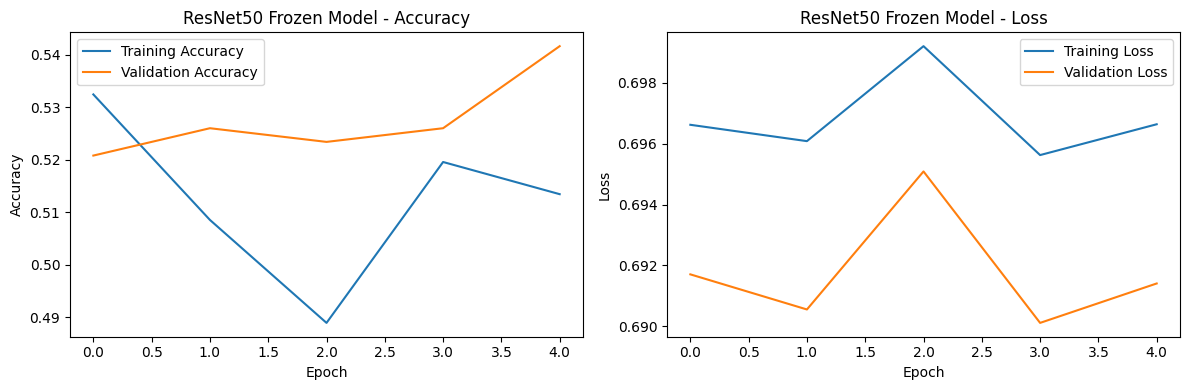

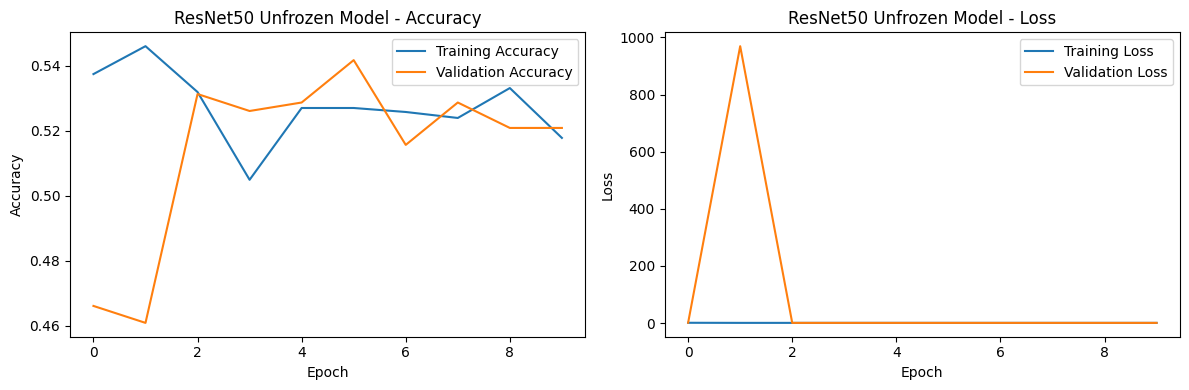

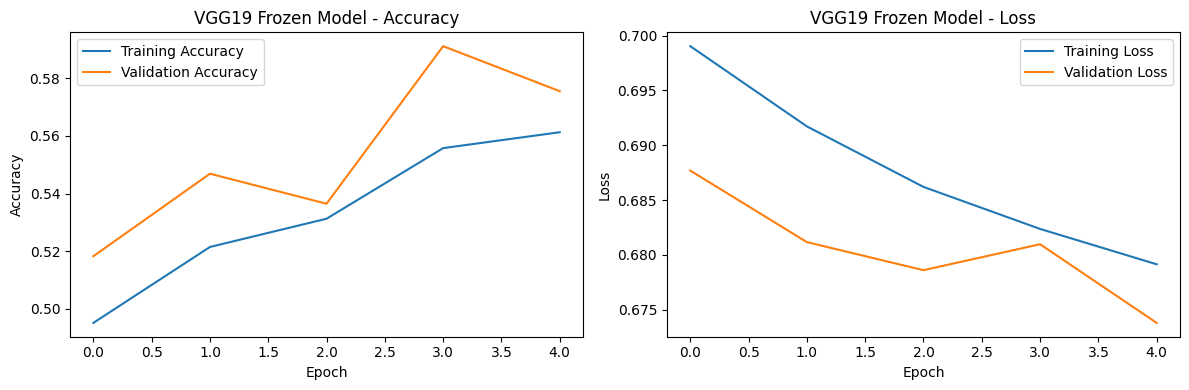

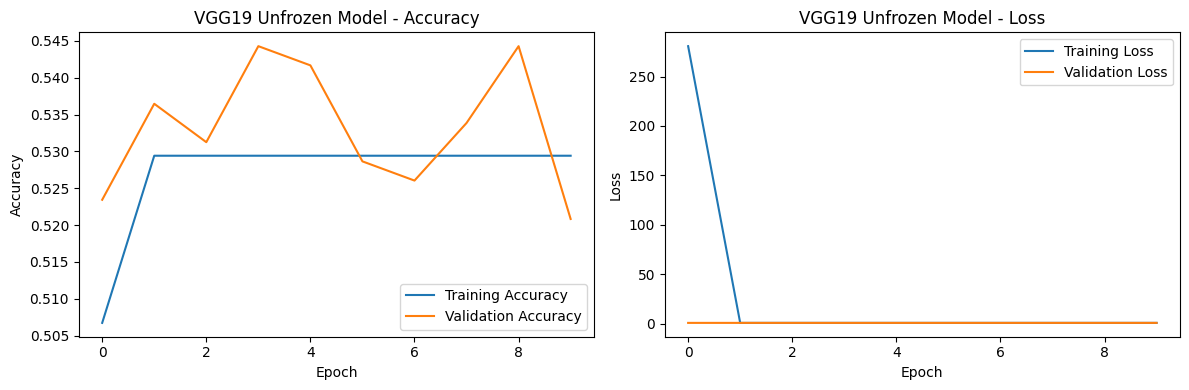

In [23]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_curves(history, title):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Model - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Model - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss curves for each model
plot_curves(history_vgg16_frozen, 'VGG16 Frozen')
plot_curves(history_vgg16_unfrozen, 'VGG16 Unfrozen')

plot_curves(history_inception_frozen, 'InceptionV3 Frozen')
plot_curves(history_inception_unfrozen, 'InceptionV3 Unfrozen')

plot_curves(history_mobilenet_frozen, 'MobileNetV2 Frozen')
plot_curves(history_mobilenet_unfrozen, 'MobileNetV2 Unfrozen')

plot_curves(history_resnet_frozen, 'ResNet50 Frozen')
plot_curves(history_resnet_unfrozen, 'ResNet50 Unfrozen')

plot_curves(history_vgg19_frozen, 'VGG19 Frozen')
plot_curves(history_vgg19_unfrozen, 'VGG19 Unfrozen')


### CNN

In [34]:
from keras import layers, models, optimizers

# Build a simple CNN model
model_cnn = models.Sequential()

# Convolutional layers
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))

# Global Average Pooling
model_cnn.add(layers.GlobalAveragePooling2D())

# Fully connected layers
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Print training and testing accuracy
training_accuracy_cnn = history_cnn.history['accuracy']
testing_accuracy_cnn = history_cnn.history['val_accuracy']

print("CNN Training Accuracy:", training_accuracy_cnn)
print("CNN Testing Accuracy:", testing_accuracy_cnn)


Epoch 1/10
51/51 [==============================] - 33s 598ms/step - loss: 0.6940 - accuracy: 0.5257 - val_loss: 0.6920 - val_accuracy: 0.5286
Epoch 2/10
51/51 [==============================] - 31s 616ms/step - loss: 0.6931 - accuracy: 0.5208 - val_loss: 0.6901 - val_accuracy: 0.5469
Epoch 3/10
51/51 [==============================] - 32s 625ms/step - loss: 0.6921 - accuracy: 0.5141 - val_loss: 0.6927 - val_accuracy: 0.5286
Epoch 4/10
51/51 [==============================] - 32s 627ms/step - loss: 0.6926 - accuracy: 0.5270 - val_loss: 0.6924 - val_accuracy: 0.5208
Epoch 5/10
51/51 [==============================] - 31s 612ms/step - loss: 0.6921 - accuracy: 0.5294 - val_loss: 0.6905 - val_accuracy: 0.5365
Epoch 7/10
51/51 [==============================] - 32s 621ms/step - loss: 0.6918 - accuracy: 0.5294 - val_loss: 0.6906 - val_accuracy: 0.5312
Epoch 8/10
51/51 [==============================] - 31s 613ms/step - loss: 0.6919 - accuracy: 0.5294 - val_loss: 0.6913 - val_accuracy: 0.5312

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load your dataset and split it into training and testing sets
# (Assuming you have a dataset of images and corresponding labels)

# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # Assuming 10 classes for classification

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, train_labels, epochs=10, 
                    validation_data=(test_generator, test_labels))

# Print training accuracy at each epoch
for epoch, acc in enumerate(history.history['accuracy'], 1):
    print(f"Epoch {epoch} - Training Accuracy: {acc}")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Accuracy:", test_acc)


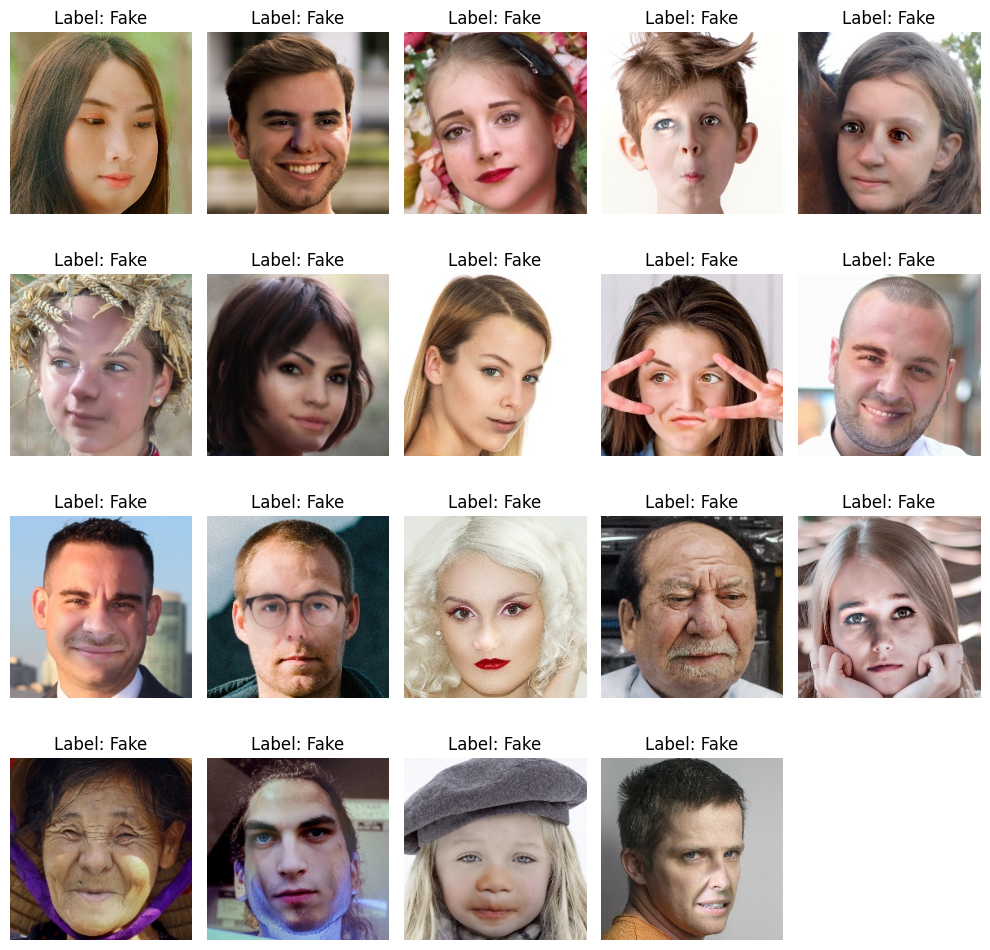

In [46]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Assuming trainset is a folder containing subfolders for each class
trainset_path = '/kaggle/working/train'

# Define a transformation to convert images to the required format
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a dataset using ImageFolder
trainset = ImageFolder(root=trainset_path, transform=transform)

# Display images and labels
classes = {1: 'Real', 0: 'Fake'}
fig = plt.figure(figsize=(10, 10))
column = 5
row = 4

for num in range(0, 19):
    image, label = trainset[num]  # Access the data using indexing
    ax = fig.add_subplot(row, column, num + 1)  # Adjust the subplot index
    image = image.permute(1, 2, 0)  # Convert tensor to image format
    ax.imshow(image)
    ax.set_title(f"Label: {classes[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()
